# To loan or not to loan - that is the question

This project consists of the development of a data mining case study. It aims to predict whether a loan will be payed back to the bank or not.

## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from joblib import parallel_backend

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, CondensedNearestNeighbour, RandomUnderSampler, TomekLinks

## Useful Functions

In [2]:
def csv_df(file, **kwargs):
    return pd.read_csv(file, sep=kwargs.pop('sep', ';'), na_values=kwargs.pop('na_values', None), dtype=kwargs.pop('dtype', None))

def age_when_loan(dataframe):
    date1 = datetime(year=dataframe['owner_year'].astype(int), month=dataframe['owner_month'].astype(int), day=1).date()
    date2 = datetime(year=dataframe['loan_year'].astype(int), month=dataframe['loan_month'].astype(int), day=1).date()
    return date2.year - date1.year - (date2.month < date1.month)

def amnt_bal_percent(transaction):
    return transaction['amount'] / transaction['balance'] * 100

def make_submission(classifier):
    x_train = final_df.drop(['loan_status'], axis=1)
    y_train = final_df['loan_status']
    x_test = test_final_df.drop(['loan_status'], axis=1)
    x_test = x_test.sort_values(by=['loan_id'])

    classifier.fit(x_train.to_numpy(), y_train.to_numpy())

    y_pred = classifier.predict_proba(x_test.to_numpy())

    print(x_test['loan_id'])

    df = pd.DataFrame(y_pred, columns=['-1', '1'])
    print(df)

    fullDF = pd.read_csv('../data/random_submission.csv')
    fullDF = fullDF.sort_values(by='Id')
    
    fullDF = fullDF.join(df)
    print(fullDF)
    
    fullDF = fullDF.drop(['Predicted', '1'], axis=1).rename(columns={'-1': 'Predicted'})

    print(fullDF.head())

    fullDF.to_csv('../data/random_submission.csv', index=False)

## Loading Data

In [3]:
account_df = csv_df('../data/account.csv')
client_df = csv_df('../data/client.csv')
disp_df = csv_df('../data/disp.csv')
transaction_df = csv_df('../data/trans_train.csv', dtype={'bank': str})
transaction_test_df = csv_df('../data/trans_test.csv')
loan_df = csv_df('../data/loan_train.csv')
loan_test_df = csv_df('../data/loan_test.csv')
card_df = csv_df('../data/card_train.csv')
card_test_df = csv_df('../data/card_test.csv')
district_df = csv_df('../data/district.csv')

## Domain Description

A Czech bank wants to improve their services using a datamining approach. The bank provides data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued, dating from 1993 to 1998. This data is provided as a set of *.csv* files.

In [4]:
print('Accounts:', account_df['account_id'].nunique())
print('Clients:', client_df['client_id'].nunique())
print('Districts:', district_df['code '].nunique())
print('Transactions:', transaction_df['trans_id'].nunique() + transaction_test_df['trans_id'].nunique())
print('Loans:', loan_df['loan_id'].nunique() + loan_test_df['loan_id'].nunique())

Accounts: 4500
Clients: 5369
Districts: 77
Transactions: 426885
Loans: 682


## Exploratory Data Analysis I

Finished loans: 85.98%
Ongoing loans: 14.02%
Districts with at least 100 clients:
1     663
74    180
70    169
54    155
64    109
72    104
Maximum number of loans on one account: 1


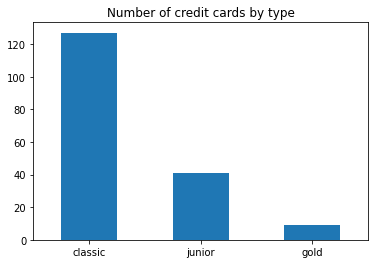

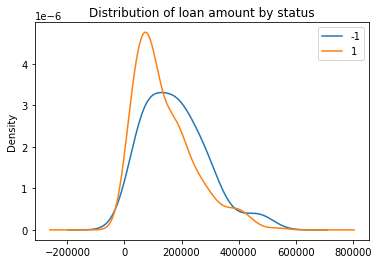

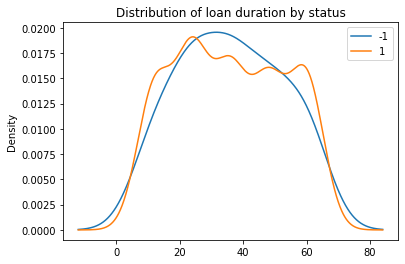

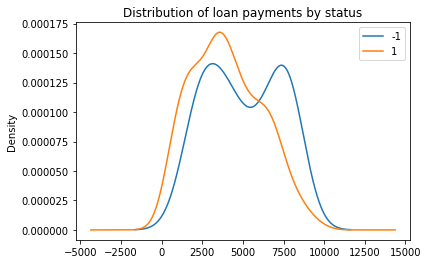

Mean percentage of transaction amount in balance: 14.22%


In [5]:
# Most loans have been payed, so 'status' is unbalanced
a, b = loan_df['status'].value_counts()

print('Finished loans: {}%'.format(round(a / (a + b) * 100, 2)))
print('Ongoing loans: {}%'.format(round(b / (a + b) * 100, 2)))

# Of all the 77 districts, only 6 have at least 100 clients
print('Districts with at least 100 clients:\n{}'.format(
    client_df.groupby('district_id').filter(lambda x: len(x) >= 100)
    ['district_id'].value_counts().to_string()))

# There's no account with more than one loan
print('Maximum number of loans on one account:', loan_df['account_id'].value_counts().max())

# Most credit cards are classic type
card_df['type'].value_counts().plot(kind='bar', rot=0)
plt.title('Number of credit cards by type')
plt.show()

# Distribution of loan characteristics according to status
loan_df.groupby('status')['amount'].plot(kind='density', legend=True)
plt.title('Distribution of loan amount by status')
plt.show()

loan_df.groupby('status')['duration'].plot(kind='density', legend=True)
plt.title('Distribution of loan duration by status')
plt.show()

loan_df.groupby('status')['payments'].plot(kind='density', legend=True)
plt.title('Distribution of loan payments by status')
plt.show()

# Mean percentage of transaction amount in balance
print('Mean percentage of transaction amount in balance: {}%'.format(
    round(transaction_df.apply(amnt_bal_percent, axis=1).mean(), 2)))

## Data Pre-processing

In [6]:
def preProcessClient(client_df):
    df = client_df.copy()
    
    # Splitting birth_number
    df['year'] = 1900 + (df['birth_number'] // 10000) # get first 2 digits
    df['day'] = df['birth_number'] % 100 # get last 2 digits
    df['mix'] = (df['birth_number'] % 10000) // 100 # get middle digits
    
    # Adding gender column
    df['gender'] = np.where(df['mix'] >= 50, 'F', 'M')
    gender_categ = pd.get_dummies(df['gender'])
    df = pd.concat((gender_categ, df), axis=1)
    df = df.drop(['gender'],axis=1)
    df = df.drop(['F'],axis=1)
    df = df.rename(columns={'M': 'gender'})
    
    # "Fixing" month, because we already have gender
    df['month'] = np.where(df['mix'] >= 50, df['mix'] - 50, df['mix'])
    
    # Removing unnecessary columns
    df = df.drop(['birth_number', 'mix'], axis=1)
    
    return df 

def preProcessDisp(disp_df):
    df = disp_df.copy()
    
    df = df.rename(columns={'type': 'disp_type'})
    
    return df

def preProcessCard(card_df):
    df = card_df.copy()
    
    df['issued'] = pd.to_datetime(df['issued'], format='%y%m%d')
    df['month'] = df['issued'].dt.month
    df['year'] = df['issued'].dt.year
    df = df.drop(['card_id'], axis=1)
    df = df.rename(columns={'type': 'card_type'})    

    return df

def preProcessDistrict(district_df):
    df = district_df.copy()
    
    # '?' Values to average: 'no. of commited crimes \'95 '
    crimes_NOTNULL = df['no. of commited crimes \'95 '] != '?'
    crimes_NULL = df['no. of commited crimes \'95 '] == '?'
    crimes_average = pd.to_numeric(df[crimes_NOTNULL]['no. of commited crimes \'95 ']).astype(float).median()
    df.loc[crimes_NULL, 'no. of commited crimes \'95 '] = crimes_average
    
    # '?' Values to average: 'unemploymant rate \'95 '
    unemploymant_NOTNULL = df['unemploymant rate \'95 '] != '?'
    unemploymant_NULL = df['unemploymant rate \'95 '] == '?'
    unemploymant_average = pd.to_numeric(df[unemploymant_NOTNULL]['unemploymant rate \'95 ']).astype(float).median()
    df.loc[unemploymant_NULL, 'unemploymant rate \'95 '] = unemploymant_average
    
    # Int -> Float, Obj -> Numeric
    df['unemploymant rate \'95 '] = df['unemploymant rate \'95 '].astype(float)
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 '] = df['unemploymant rate \'96 '].astype(float)
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])
    df['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(df['no. of enterpreneurs per 1000 inhabitants '])
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '].astype(float)
    
    # Ratio: 0-1
    df['entrepeneurs ratio'] = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '] / 100
    
    # 95-96 Increase on Crimes and Unemploymant
    df['crimes_increase'] = (df['no. of commited crimes \'96 '] - df['no. of commited crimes \'95 ']) / df['no. of inhabitants']
    df['unemploymant_increase'] = df['unemploymant rate \'96 '] - df['unemploymant rate \'95 ']

    # Removing unnecessary columns
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants ', 
                 'unemploymant rate \'96 ', 'no. of commited crimes \'96 ',
                  'unemploymant rate \'95 ', 'no. of commited crimes \'95 ', 'name ', 'region'], axis=1)        
    
    df = df.rename(columns={'code ': 'district_id'})

    return df

def preProcessAccount(account_df):
    df = account_df.copy()
    
    # Splitting account creation date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Removing unnecessary columns
    df = df.drop(['date', 'day', 'frequency', 'district_id'], axis=1)
    
    return df
    
def preProcessLoan(loan_df):
    df = loan_df.copy()
    
    # Splitting loan grant date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Removing unnecessary columns
    df = df.drop(['date'], axis=1)
    
    return df
    
def preProcessTransaction(transaction_df):
    df = transaction_df.copy()
    
    # Splitting loan grant date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Replacing values in type column
    df['type'].replace({'credit': 1, 'withdrawal': -1, 'withdrawal in cash': -1}, inplace=True)
    
    # Removing unnecessary columns
    df = df.drop(['date', 'bank', 'account', 'operation', 'k_symbol'], axis=1)
    
    return df

In [7]:
preProcessedClient_df = preProcessClient(client_df)
preProcessedDisp_df = preProcessDisp(disp_df)
preProcessedCard_df = preProcessCard(card_df)
preProcessedDistrict_df = preProcessDistrict(district_df)
preProcessedAccount_df = preProcessAccount(account_df)
preProcessedLoan_df = preProcessLoan(loan_df)
preProcessedTransaction_df = preProcessTransaction(transaction_df)

## Exploratory Data Analysis II

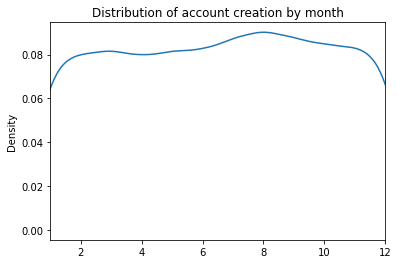

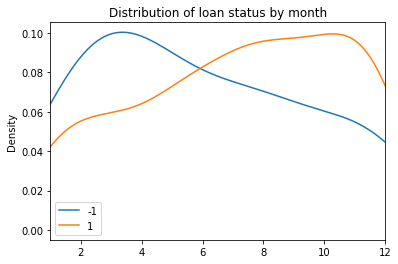

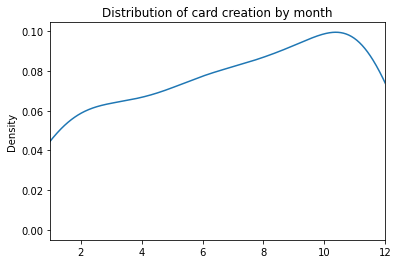

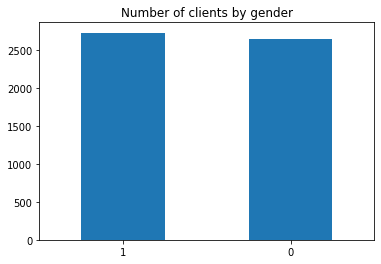

In [8]:
# Distribution of account creation by month
preProcessedAccount_df['month'].plot(kind='density', xlim=(1, 12))
plt.title('Distribution of account creation by month')
plt.show()

# Distribution of loan status by month
preProcessedLoan_df.groupby('status')['month'].plot(kind='density', legend=True, xlim=(1, 12))
plt.title('Distribution of loan status by month')
plt.show()

# Distribution of card creation by month
preProcessedCard_df['issued'].dt.month.plot(kind='density', xlim=(1, 12))
plt.title('Distribution of card creation by month')
plt.show()

# Client gender is almost evenly distributed between male and female
preProcessedClient_df['gender'].value_counts().plot(kind='bar', rot=0)
plt.title('Number of clients by gender')
plt.show()

## Merging Data

In [9]:
# Merging Disp, Client, Card and District
def processRightSide(client, disp, card, district):
    client_df = client.copy()
    disp_df = disp.copy()
    card_df = card.copy()
    card_df = card_df.drop(['issued'], axis=1)
    district_df = district.copy()

    # Clients and Districts don't mix with anything else, so let's merge them
    client_district_df = client_df.merge(district_df, on='district_id', how='left')

    # Merging Disp and Card so we can eliminate disp_id when group by account
    disp_card_df = disp_df.merge(card_df, on='disp_id', how='left')
    disp_card_df = disp_card_df.drop(['disp_id'], axis=1)

    rightSide = disp_card_df.pivot(index='account_id', columns=['disp_type']).droplevel([0], axis=1).set_axis(['disponent_id', 'owner_id', 'disponent_card_type', 'owner_card_type', 'disponent_issued_card_month', 'owner_issued_card_month', 'disponent_issued_card_year', 'owner_issued_card_year'], axis=1).reset_index()

    rightSide = rightSide.merge(client_district_df, left_on='owner_id', right_on='client_id', how='left')
    rightSide = rightSide.merge(client_district_df, left_on='disponent_id', right_on='client_id', how='left', suffixes=('', '_disp'))

    rightSide = rightSide.drop(['client_id', 'client_id_disp', 'district_id', 'district_id_disp', 'disponent_card_type', 'disponent_issued_card_month', 'disponent_issued_card_year'], axis=1)
    rightSide = rightSide.drop(['owner_issued_card_month', 'owner_issued_card_year'], axis=1)
    
    rightSide = rightSide.rename(columns={'gender': 'owner_gender', 'year': 'owner_year', 'day': 'owner_day', 'month': 'owner_month', 'no. of inhabitants': 'owner_num_inhabitants',
        'no. of municipalities with inhabitants < 499 ': 'owner_num_municipalities_less_499',
        'no. of municipalities with inhabitants 500-1999': 'owner_num_municipalities_between_500_1999',
        'no. of municipalities with inhabitants 2000-9999 ': 'owner_num_municipalities_between_2000_9999',
        'no. of municipalities with inhabitants >10000 ': 'owner_num_municipalities_more_10000',
        'no. of cities ': 'owner_num_cities', 'ratio of urban inhabitants ': 'owner_inhabitants_ratio',
        'average salary ': 'owner_average_salary', 'entrepeneurs ratio': 'owner_entrepeneurs_ratio',
        'crimes_increase': 'owner_crimes_increase', 'unemploymant_increase': 'owner_unemploymant_increase'})
    rightSide = rightSide.rename(columns={'gender_disp': 'disponent_gender', 'year_disp': 'disponent_year', 'day_disp': 'disponent_day', 'month_disp': 'disponent_month', 'no. of inhabitants_disp': 'disponent_num_inhabitants',
        'no. of municipalities with inhabitants < 499 _disp': 'disponent_num_municipalities_less_499',
        'no. of municipalities with inhabitants 500-1999_disp': 'disponent_num_municipalities_between_500_1999',
        'no. of municipalities with inhabitants 2000-9999 _disp': 'disponent_num_municipalities_between_2000_9999',
        'no. of municipalities with inhabitants >10000 _disp': 'disponent_num_municipalities_more_10000',
        'no. of cities _disp': 'disponent_num_cities', 'ratio of urban inhabitants _disp': 'disponent_inhabitants_ratio',
        'average salary _disp': 'disponent_average_salary', 'entrepeneurs ratio_disp': 'disponent_entrepeneurs_ratio',
        'crimes_increase_disp': 'disponent_crimes_increase', 'unemploymant_increase_disp': 'disponent_unemploymant_increase'})
    
    rightSide = pd.get_dummies(rightSide)
    
    rightSide.drop(['disponent_gender', 'disponent_year', 'disponent_month',
                    'disponent_num_inhabitants', 'disponent_num_municipalities_less_499',
                    'disponent_num_municipalities_between_500_1999','disponent_num_municipalities_between_2000_9999',
                    'disponent_num_municipalities_more_10000','disponent_num_cities','disponent_inhabitants_ratio',
                    'disponent_average_salary','disponent_entrepeneurs_ratio','disponent_crimes_increase', 'disponent_unemploymant_increase'], axis=1)
    
    return rightSide

rightSide = processRightSide(preProcessedClient_df, preProcessedDisp_df, preProcessedCard_df, preProcessedDistrict_df)
display(rightSide)
print(rightSide.info())

,account_id,disponent_id,owner_id,owner_gender,owner_year,owner_day,owner_month,owner_num_inhabitants,owner_num_municipalities_less_499,owner_num_municipalities_between_500_1999,...,disponent_num_municipalities_more_10000,disponent_num_cities,disponent_inhabitants_ratio,disponent_average_salary,disponent_entrepeneurs_ratio,disponent_crimes_increase,disponent_unemploymant_increase,owner_card_type_classic,owner_card_type_gold,owner_card_type_junior
0,1,NaN,1.0,0,1970,13,12,70699,60,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2,3.0,2.0,1,1945,4,2,1204953,0,0,...,1.0,1.0,1.000,12541.0,0.167,0.011146,0.14,0,0,0
2,3,5.0,4.0,1,1956,1,12,95616,65,30,...,1.0,6.0,0.514,9307.0,0.118,0.004434,0.58,0,0,0
3,4,NaN,6.0,1,1919,22,9,107870,84,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,5,NaN,7.0,1,1929,25,1,58796,22,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,11333,NaN,13931.0,1,1942,1,1,112065,95,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4496,11349,13956.0,13955.0,0,1945,30,10,1204953,0,0,...,1.0,1.0,1.000,12541.0,0.167,0.011146,0.14,0,0,0
4497,11359,NaN,13968.0,1,1968,13,4,117897,139,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4498,11362,NaN,13971.0,0,1962,19,10,106054,38,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 4499
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   account_id                                      4500 non-null   int64  
 1   disponent_id                                    869 non-null    float64
 2   owner_id                                        4500 non-null   float64
 3   owner_gender                                    4500 non-null   uint8  
 4   owner_year                                      4500 non-null   int64  
 5   owner_day                                       4500 non-null   int64  
 6   owner_month                                     4500 non-null   int64  
 7   owner_num_inhabitants                           4500 non-null   int64  
 8   owner_num_municipalities_less_499               4500 non-null   int64  
 9   owner_num_municipalities_between_500_1999

In [10]:
# Merging Account, Loan, Transaction
def processTransaction(pPTransaction_df):
    df = pPTransaction_df.copy()
    df = df.drop(['trans_id'], axis=1)

    # Get several GroupBy Objects
    gb = df.groupby(['account_id'])
    gb_type = df.groupby(['account_id', 'type'])
    gb_year = df.groupby(['account_id', 'year'])
    gb_year_type = df.groupby(['account_id', 'year', 'type'])
    
    # Get statistics for balance after each transaction
    balance_all = gb.agg({'balance': ['mean', 'min', 'max']}).droplevel(1, axis=1).set_axis(['balance_mean', 'balance_min', 'balance_max'], axis=1)
    
    # Get statistics for number of transactions of each type
    no_of_type_transactions = gb_type.size().to_frame().reset_index().pivot(index='account_id', columns='type').droplevel(['type'], axis=1).set_axis(['debits', 'credits'], axis=1)
    
    # Get statistics for transaction amount and balance after transaction for each type
    amount_balance_type = gb_type.agg({'amount': ['sum', 'mean', 'min', 'max'], 'balance': ['mean', 'min', 'max']}).reset_index().pivot(index='account_id', columns='type').droplevel([0, 'type'], axis=1).set_axis(['amount_sum_debit', 'amount_sum_credit', 'amount_mean_debit', 'amount_mean_credit', 'amount_min_debit', 'amount_min_credit', 'amount_max_debit', 'amount_max_credit', 'balance_mean_debit', 'balance_mean_credit', 'balance_min_debit', 'balance_min_credit', 'balance_max_debit', 'balance_max_credit'], axis=1)
    
    # Get statistics for number of transactions of each year
    no_of_year_transactions = gb_year.size().to_frame().reset_index().pivot(index='account_id', columns='year').droplevel(['year'], axis=1).set_axis(['no. of transactions 1993', 'no. of transactions 1994', 'no. of transactions 1995', 'no. of transactions 1996'], axis=1).fillna(0)
    
    # Get statistics for balance after transaction for each year
    balance_all_year = gb_year.agg({'balance': ['mean', 'min', 'max']}).reset_index().pivot(index='account_id', columns='year').droplevel([0, 1], axis=1).set_axis(['balance_mean_1993', 'balance_mean_1994', 'balance_mean_1995', 'balance_mean_1996', 'balance_min_1993', 'balance_min_1994', 'balance_min_1995', 'balance_min_1996', 'balance_max_1993', 'balance_max_1994', 'balance_max_1995', 'balance_max_1996'], axis=1)
    
    # Get statistics for number of transactions of each type in each year
    no_of_year_type_transactions = gb_year_type.size().to_frame().reset_index().pivot(index='account_id', columns=['year', 'type']).droplevel([0, 1], axis=1).set_axis(['1995_debits', '1995_credits', '1996_debits', '1996_credits', '1993_debits', '1993_credits', '1994_debits', '1994_credits'], axis=1)
    
    # Get statistics for transaction amount and balance after transaction for each type in each year
    amount_balance_year_type = gb_year_type.agg({'amount': ['sum', 'mean', 'min', 'max'], 'balance': ['mean', 'min', 'max']}).reset_index().pivot(index='account_id', columns=['year', 'type']).droplevel([0, 1], axis=1).set_axis(['amount_sum_1993_debit', 'amount_sum_1993_credit', 'amount_sum_1994_debit', 'amount_sum_1994_credit', 'amount_sum_1995_debit', 'amount_sum_1995_credit', 'amount_sum_1996_debit', 'amount_sum_1993_credit', 'amount_mean_1993_debit', 'amount_mean_1993_credit', 'amount_mean_1994_debit', 'amount_mean_1994_credit', 'amount_mean_1995_debit', 'amount_mean_1995_credit', 'amount_mean_1996_debit', 'amount_mean_1996_credit', 'amount_min_1993_debit', 'amount_min_1993_credit', 'amount_min_1994_debit', 'amount_min_1994_credit', 'amount_min_1995_debit', 'amount_min_1995_credit', 'amount_min_1996_debit', 'amount_min_1996_credit', 'amount_max_1993_debit', 'amount_max_1993_credit', 'amount_max_1994_debit', 'amount_max_1994_credit', 'amount_max_1995_debit', 'amount_max_1995_credit', 'amount_max_1996_debit', 'amount_max_1996_credit', 'balance_mean_1993_debit', 'balance_mean_1993_credit', 'balance_mean_1994_debit', 'balance_mean_1994_credit', 'balance_mean_1995_debit', 'balance_mean_1995_credit', 'balance_mean_1996_debit', 'balance_mean_1996_credit', 'balance_min_1993_debit', 'balance_min_1993_credit', 'balance_min_1994_debit', 'balance_min_1994_credit', 'balance_min_1995_debit', 'balance_min_1995_credit', 'balance_min_1996_debit', 'balance_min_1996_credit', 'balance_max_1993_debit', 'balance_max_1993_credit', 'balance_max_1994_debit', 'balance_max_1994_credit', 'balance_max_1995_debit', 'balance_max_1995_credit', 'balance_max_1996_debit', 'balance_max_1996_credit'], axis=1)
    
    # Get balance from last transaction
    last_balance = df.sort_values(['account_id', 'year', 'month', 'day'], ascending=False).groupby('account_id').first()['balance'].to_frame('last_balance')

    # Get new dataframe with number of transactions for each account
    counts = gb.size().to_frame(name='no. of transactions')
    
    # Join all the data for each account
    counts = counts.join(balance_all).join(last_balance).join(no_of_type_transactions).join(amount_balance_type).join(no_of_year_transactions).join(balance_all_year).join(no_of_year_type_transactions).join(amount_balance_year_type).reset_index().fillna(0)
    
    return counts

    
processedTransaction_df = processTransaction(preProcessedTransaction_df)

def joinAccountTransaction(pPAccount_df, pTransaction_df):
    df = pPAccount_df.rename(columns={'year': 'account_year', 'month': 'account_month'})
    
    df = df.set_index('account_id').join(pTransaction_df.set_index('account_id'))
    
    return df

accountTransaction_df = joinAccountTransaction(preProcessedAccount_df, processedTransaction_df)
display(processedTransaction_df)

,account_id,no. of transactions,balance_mean,balance_min,balance_max,last_balance,debits,credits,amount_sum_debit,amount_sum_credit,...,balance_min_1996_debit,balance_min_1996_credit,balance_max_1993_debit,balance_max_1993_credit,balance_max_1994_debit,balance_max_1994_credit,balance_max_1995_debit,balance_max_1995_credit,balance_max_1996_debit,balance_max_1996_credit
0,1,113,17558.700000,1000.0,30414.8,12659.9,63.0,50.0,86970.2,99630.1,...,11127.5,12674.5,0.0,0.0,0.0,0.0,26635.2,30414.8,19724.8,20525.5
1,2,54,32590.624074,1100.0,67529.6,27840.6,32.0,22.0,200844.6,228685.3,...,0.0,0.0,49180.5,67529.6,0.0,0.0,0.0,0.0,0.0,0.0
2,4,39,23648.623077,800.0,30623.5,24943.0,22.0,17.0,31977.6,56920.5,...,20509.0,800.0,0.0,0.0,0.0,0.0,0.0,0.0,27622.0,30623.5
3,6,124,30313.279839,900.0,40391.5,33509.2,73.0,51.0,150277.8,183787.0,...,20377.3,23201.2,0.0,0.0,0.0,20907.0,36437.5,40391.5,38553.7,39833.7
4,7,4,23088.850000,900.0,34875.0,28305.4,1.0,3.0,6600.0,34905.4,...,28275.0,900.0,0.0,0.0,0.0,0.0,0.0,0.0,28275.0,34875.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3365,11333,208,36827.658173,-1291.0,137043.2,19790.4,107.0,101.0,885468.1,905244.3,...,8030.3,14006.1,0.0,0.0,107843.2,137043.2,50420.1,29126.9,102695.2,107252.8
3366,11349,18,59352.833333,200.0,104039.9,24704.4,7.0,11.0,207486.0,232190.5,...,0.0,0.0,0.0,0.0,0.0,0.0,66339.9,104039.9,0.0,0.0
3367,11359,147,36480.185034,1000.0,81705.8,25682.6,102.0,45.0,627249.8,652932.4,...,8615.9,18102.5,0.0,0.0,54520.9,80620.9,65574.2,81705.8,42856.7,68376.4
3368,11362,107,30869.781308,1000.0,56055.6,24199.5,78.0,29.0,231341.4,255541.0,...,14067.2,14888.5,0.0,0.0,0.0,0.0,35303.1,44303.1,55926.6,56055.6


In [11]:
# Merging merge1 and merge2 (by account_id)
def merge12(merge1, merge2):
    
    merge12_df = merge2.merge(merge1, on='account_id')
    
    return merge12_df.fillna(0)
    
merge12_df = merge12(accountTransaction_df, rightSide)
display(merge12_df)

,account_id,disponent_id,owner_id,owner_gender,owner_year,owner_day,owner_month,owner_num_inhabitants,owner_num_municipalities_less_499,owner_num_municipalities_between_500_1999,...,balance_min_1996_debit,balance_min_1996_credit,balance_max_1993_debit,balance_max_1993_credit,balance_max_1994_debit,balance_max_1994_credit,balance_max_1995_debit,balance_max_1995_credit,balance_max_1996_debit,balance_max_1996_credit
0,1,0.0,1.0,0,1970,13,12,70699,60,13,...,11127.5,12674.5,0.0,0.0,0.0,0.0,26635.2,30414.8,19724.8,20525.5
1,2,3.0,2.0,1,1945,4,2,1204953,0,0,...,0.0,0.0,49180.5,67529.6,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5.0,4.0,1,1956,1,12,95616,65,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,6.0,1,1919,22,9,107870,84,29,...,20509.0,800.0,0.0,0.0,0.0,0.0,0.0,0.0,27622.0,30623.5
4,5,0.0,7.0,1,1929,25,1,58796,22,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,11333,0.0,13931.0,1,1942,1,1,112065,95,19,...,8030.3,14006.1,0.0,0.0,107843.2,137043.2,50420.1,29126.9,102695.2,107252.8
4496,11349,13956.0,13955.0,0,1945,30,10,1204953,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,66339.9,104039.9,0.0,0.0
4497,11359,0.0,13968.0,1,1968,13,4,117897,139,28,...,8615.9,18102.5,0.0,0.0,54520.9,80620.9,65574.2,81705.8,42856.7,68376.4
4498,11362,0.0,13971.0,0,1962,19,10,106054,38,25,...,14067.2,14888.5,0.0,0.0,0.0,0.0,35303.1,44303.1,55926.6,56055.6


In [12]:
# Final merge: merge12 with loans
def finalMerge(merge12, loans):
    final_df = merge12.merge(loans, on='account_id')
    final_df = final_df.rename(columns={'amount': 'loan_amount', 
        'duration': 'loan_duration', 'payments': 'loan_payments',
        'year': 'loan_year', 'month': 'loan_month',
        'status': 'loan_status', 'day': 'loan_day'})
    final_df = final_df.drop(['owner_id', 'disponent_id', 'account_id'], axis=1)
    
    return final_df

final_df = finalMerge(merge12_df, preProcessedLoan_df)

# Create "months until account reaches 0 if there are no more credits" feature
final_df['months_until_0'] = final_df['last_balance'] / final_df['loan_payments']

# Create "age in days" feature
final_df['age'] = (final_df['loan_year'] * 365 + final_df['loan_month'] * 30 + final_df['loan_day']) - (final_df['owner_year'] * 365 + final_df['owner_month'] * 30 + final_df['owner_day'])

display(final_df)

,owner_gender,owner_year,owner_day,owner_month,owner_num_inhabitants,owner_num_municipalities_less_499,owner_num_municipalities_between_500_1999,owner_num_municipalities_between_2000_9999,owner_num_municipalities_more_10000,owner_num_cities,...,loan_id,loan_amount,loan_duration,loan_payments,loan_status,loan_year,loan_day,loan_month,months_until_0,age
0,1,1945,4,2,1204953,0,0,0,1,1,...,4959,80952,24,3373,1,1994,5,1,8.253958,17856
1,0,1939,23,4,103347,87,16,7,1,7,...,4961,30276,12,2523,-1,1996,29,4,6.283789,20811
2,0,1944,13,6,93931,74,21,10,1,8,...,4973,165960,24,6915,1,1996,2,5,3.425770,18939
3,0,1945,3,7,128118,9,16,6,3,8,...,4996,88440,12,7370,1,1996,6,11,10.706594,18738
4,1,1939,30,11,125832,151,41,2,3,5,...,5002,104808,12,8734,1,1994,31,5,3.207625,19896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,0,1980,13,11,107870,84,29,6,1,6,...,7271,392460,60,6541,1,1996,2,10,8.140208,5799
324,1,1973,16,2,58796,22,16,7,1,5,...,7284,52788,12,4399,1,1993,15,9,4.780405,7509
325,0,1945,30,10,1204953,0,0,0,1,1,...,7304,419880,60,6998,1,1995,29,10,3.530209,18249
326,1,1968,13,4,117897,139,28,5,1,6,...,7305,54024,12,4502,1,1996,6,8,5.704709,10333


## Exploratory Data Analysis III

0.022487142349834354


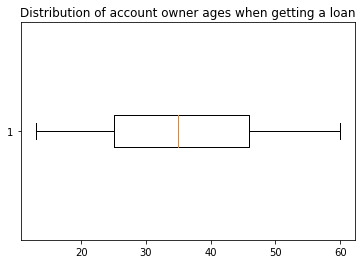

In [13]:
# Correlation between gender and loan status
print(final_df['owner_gender'].corr(final_df['loan_status']))

# Distribution of account owner ages when getting a loan
plt.boxplot(final_df.apply(age_when_loan, axis=1), vert=False)
plt.title('Distribution of account owner ages when getting a loan')
plt.show()

In [14]:
preProcessedCardTest_df = preProcessCard(card_test_df)
preProcessedLoanTest_df = preProcessLoan(loan_test_df)
preProcessedTransactionTest_df = preProcessTransaction(transaction_test_df)

In [15]:
test1 = processRightSide(preProcessedClient_df, preProcessedDisp_df, preProcessedCardTest_df, preProcessedDistrict_df)
test2 = processTransaction(preProcessedTransactionTest_df)
test2 = joinAccountTransaction(preProcessedAccount_df, test2)
test3 = merge12(test2, test1)
test_final_df = finalMerge(test3, preProcessedLoanTest_df)

# Create "months until account reaches 0 if there are no more credits" feature
test_final_df['months_until_0'] = test_final_df['last_balance'] / test_final_df['loan_payments']

# Create "age in days" feature
test_final_df['age'] = (test_final_df['loan_year'] * 365 + test_final_df['loan_month'] * 30 + test_final_df['loan_day']) - (test_final_df['owner_year'] * 365 + test_final_df['owner_month'] * 30 + test_final_df['owner_day'])

display(test_final_df)

,owner_gender,owner_year,owner_day,owner_month,owner_num_inhabitants,owner_num_municipalities_less_499,owner_num_municipalities_between_500_1999,owner_num_municipalities_between_2000_9999,owner_num_municipalities_more_10000,owner_num_cities,...,loan_id,loan_amount,loan_duration,loan_payments,loan_status,loan_year,loan_day,loan_month,months_until_0,age
0,1,1962,9,2,228848,15,40,18,2,6,...,4962,30276,12,2523,NaN,1997,8,12,12.533452,13074
1,1,1952,26,8,70646,94,14,3,1,4,...,4967,318480,60,5308,NaN,1998,14,10,3.083610,16838
2,0,1940,30,1,51428,50,11,3,1,4,...,4968,110736,48,2307,NaN,1998,19,4,16.218769,21249
3,1,1942,28,1,323870,0,0,0,1,1,...,4986,102876,12,8573,NaN,1997,10,8,4.726035,20267
4,1,1967,21,9,105606,77,26,7,2,7,...,4988,265320,36,7370,NaN,1997,6,12,2.710339,11025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0,1948,31,7,133777,24,17,7,3,11,...,7279,155760,24,6490,NaN,1997,11,12,8.543467,18015
350,1,1972,26,1,95616,65,30,4,1,6,...,7286,67320,36,1870,NaN,1997,31,1,10.565508,9130
351,1,1975,20,11,102609,75,33,2,3,6,...,7292,317460,60,5291,NaN,1998,22,11,14.460121,8397
352,0,1979,22,2,94725,38,28,1,3,6,...,7294,39168,24,1632,NaN,1998,27,9,38.063235,7150


## Feature Selection

In [16]:
# Create correlation matrix
corr_matrix = final_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
final_df.drop(to_drop, axis=1, inplace=True)
test_final_df.drop(to_drop, axis=1, inplace=True)

import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(final_df.drop(['loan_id', 'loan_status'], axis=1).values, final_df['loan_status'].values, SL, final_df.drop(['loan_id','loan_status'], axis=1).columns)

pd.options.mode.chained_assignment = None
test = pd.DataFrame(data = data_modeled, columns = selected_columns)
test['loan_status'] = final_df['loan_status']
test['loan_id'] = final_df['loan_id']

final_df = test

test = test_final_df[selected_columns]
test['loan_status'] = test_final_df['loan_status']
test['loan_id'] = test_final_df['loan_id']

test_final_df = test

## Saving DataFrames as CSV

In [17]:
final_df.to_csv("train.csv")
test_final_df.to_csv("test.csv")

## Model Training

In [18]:
x = final_df.drop(['loan_status'], axis=1)
y = final_df['loan_status']

cross_validation = StratifiedKFold(n_splits=10)

In [19]:
over = [SMOTE(), ADASYN(), RandomOverSampler()]
under = [EditedNearestNeighbours(), CondensedNearestNeighbour(), RandomUnderSampler(), TomekLinks()]

def resamplingGridSearch(classifier, params):
    best = {
        'resampler': [],
        'score': 0,
        'parameters': {}
    }
    
    for o in over:
        for u in under:
            pl = Pipeline([('o', o), ('u', u), ('classification', classifier)])
            
            grid_search = GridSearchCV(pl, params, cv=cross_validation, scoring='roc_auc', n_jobs=-1, verbose=3)

            with parallel_backend('threading', n_jobs=-1):
                grid_search.fit(x.to_numpy(), y.to_numpy())

                print('Resamplers: {} and {}'.format(o, u))
                print('Best score: {}'.format(grid_search.best_score_))
                print('Best parameters: {}'.format(grid_search.best_params_))
            
            if grid_search.best_score_ > best["score"]:
                best.update({'resampler': [o, u], 'score': grid_search.best_score_, 'parameters': grid_search.best_params_})
    
    return best

In [20]:
# # Random Forest

# rf_classifier = RandomForestClassifier()

# rf_parameter_grid = {
#     'classification__n_estimators': [100, 500],
#     'classification__criterion': ['gini', 'entropy'],
#     'classification__min_samples_split': [0.1, 0.3, 0.5],
#     'classification__max_features': [None, 'sqrt', 'log2', 0.2, 0.5, 0.8]
# }

# best_rf = resamplingGridSearch(rf_classifier, rf_parameter_grid)

# print(best_rf)

# Fitting 10 folds for each of 72 candidates, totalling 720 fits
# {'resampler': [SMOTE(), RandomUnderSampler()],
#  'score': 0.9173152709359608,
#  'parameters': {
#       'classification__criterion': 'entropy',
#       'classification__max_features': 0.2, 
#       'classification__min_samples_split': 0.5,
#       'classification__n_estimators': 500}}

In [21]:
# # SVM

# svm_classifier = SVC()

# svm_parameter_grid = {
#     'classification__kernel': ['poly', 'rbf'],
#     'classification__C': [0.1, 1, 10],
#     'classification__gamma': [0.1, 1]
# }

# best_svm = resamplingGridSearch(svm_classifier, svm_parameter_grid)

# print(best_svm)

# Fitting 10 folds for each of 12 candidates, totalling 120 fits
# {'resampler': [ADASYN(), EditedNearestNeighbours()], 
#  'score': 0.7657142857142857, 
#  'parameters': {
#       'classification__C': 1,
#       'classification__gamma': 1,
#       'classification__kernel': 'poly'}}

In [22]:
# # Logistic Regression

# logreg_classifier = LogisticRegression()

# logreg_parameter_grid = {
#     'classification__penalty': ['l1', 'l2', None],
#     'classification__class_weight':['balanced', None],
#     'classification__C': [0.1, 1, 10],
#     'classification__solver': ['saga']
# }

# best_logreg = resamplingGridSearch(logreg_classifier, logreg_parameter_grid)

# print(best_logreg)

# Fitting 10 folds for each of 18 candidates, totalling 180 fits
# {'resampler': [RandomOverSampler(), TomekLinks()],
#  'score': 0.8546305418719212,
#  'parameters': {
#       'classification__C': 10,
#       'classification__class_weight': None,
#       'classification__penalty': 'none',
#       'classification__solver': 'saga'}}

In [23]:
# # Linear SVR

# linearSVR_classifier = LinearSVR()

# linearSVR_parameter_grid = {
#     'classification__C': [0.1, 1, 10],
#     'classification__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
#     'classification__fit_intercept':[True, False],
#     'classification__max_iter': [500, 1000, 2000]
# }

# best_linearSVR = resamplingGridSearch(linearSVR_classifier, linearSVR_parameter_grid)

# print(best_linearSVR)

# Fitting 10 folds for each of 36 candidates, totalling 360 fits
# {'resampler': [SMOTE(), TomekLinks()],
#  'score': 0.8794211822660101,
#  'parameters': {
#       'classification__C': 0.1,
#       'classification__loss': False,
#       'classification__fit_intercept': 'epsilon_insensitive',
#       'classification__max_iter': 500}}

In [24]:
# # GaussianNB

# gaussianNB_classifier = GaussianNB()

# gaussianNB_parameter_grid = {
#     'classification__var_smoothing': np.logspace(0,-9, num=100)
# }

# best_gaussianNB = resamplingGridSearch(gaussianNB_classifier, gaussianNB_parameter_grid)

# print(best_gaussianNB)

# Fitting 10 folds for each of 100 candidates, totalling 1000 fits
# {'resampler': [RandomOverSampler(), TomekLinks()],
#  'score': 0.8798460591133004,
#  'parameters': {
#       'classification__var_smoothing': 1.2328467394420635e-09}}

In [25]:
# res = RandomForestClassifier(criterion='entropy', max_features=0.2, min_samples_split=0.5, n_estimators=500)
# make_submission(Pipeline([('o', RandomOverSampler()), ('u', RandomUnderSampler()), ('classification', res)]))

# {'resampler': [RandomOverSampler(), RandomUnderSampler()],
# 'score': 0.9114901477832513,
#'parameters': {'classification__criterion': 'entropy', 'classification__max_features': 0.2, 
#               'classification__min_samples_split': 0.5, 'classification__n_estimators': 500}}

## Clustering

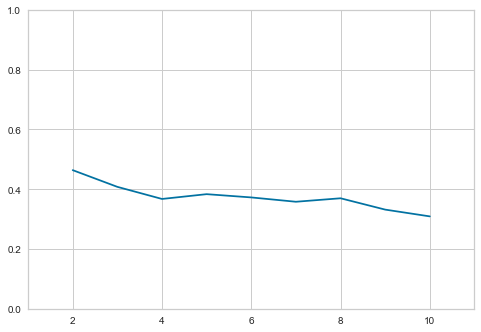

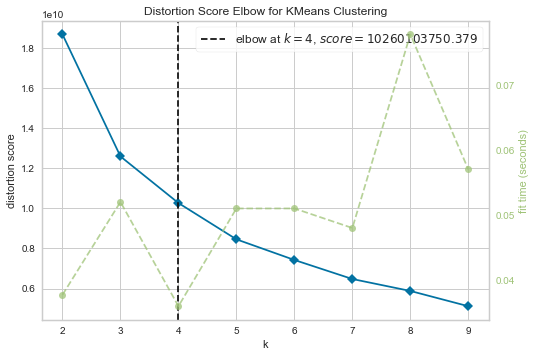

,Cluster,0
0,0,143
1,1,185


disponent_inhabitants_ratio
owner_card_type_gold
no. of transactions
balance_min
balance_min_debit
balance_min_credit
amount_min_1995_debit
amount_min_1996_debit
loan_payments
loan_status
loan_id
Cluster


<AxesSubplot:xlabel='Cluster,loan_status'>

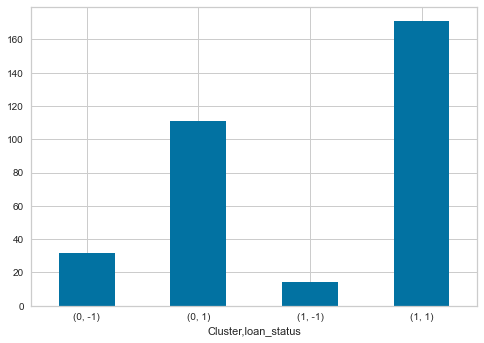

In [50]:
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

#Silhouette Score
plt.axis([1, 11, 0, 1])
scores = []
for i in range(2, 11):
    km = cluster.KMeans(n_clusters=i, init='k-means++', n_init=50, max_iter=100, random_state=42)
    km.fit_predict(final_df)
    score = metrics.silhouette_score(final_df, km.labels_, metric='euclidean')
    scores.append(score)
plt.plot(range(2,11), scores)
plt.show()

#Elbow Method
visualizer = KElbowVisualizer(cluster.KMeans(), k=(2,10))

visualizer.fit(final_df)    
visualizer.poof();

#Using 5 clusters
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(final_df)
groups = kmeans.labels_

clustered_df = pd.DataFrame(final_df)
clustered_df['Cluster'] = groups

## Describing Clusters

#Cluster Size
gb = clustered_df.groupby('Cluster')

display(gb.size().to_frame().reset_index())

# for c in clustered_df.columns:
#     clustered_df.boxplot(column=c, by='Cluster')

for c in final_df.columns:
    print(c)

#Cluster loan status
gb_ln = clustered_df.groupby(['Cluster', 'loan_status'])
gb_ln.size().plot(kind='bar', rot=0)